<a href="https://colab.research.google.com/github/muralikrishnan2022/OTDR_Fault_Analysis/blob/main/BDT_Fault_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
# Load the dataset
data = pd.read_csv('/content/OTDR_data.csv')

# Drop any rows with missing values
data = data.dropna()

# Separate features and labels
features = data[['SNR'] + [f'P{i}' for i in range(1, 31)] + ['Reflectance', 'loss']]
target_class = data['Class']
target_position = data['Position']


In [ ]:
# Split the data for training and testing
X_train, X_test, y_train_class, y_test_class = train_test_split(features, target_class, test_size=0.2, random_state=42)
X_train, X_test, y_train_pos, y_test_pos = train_test_split(features, target_position, test_size=0.2, random_state=42)

In [ ]:
# Reshape data for RNN (samples, timesteps, features)
X_train_rnn = np.expand_dims(X_train.values, axis=2)
X_test_rnn = np.expand_dims(X_test.values, axis=2)

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=False))
rnn_model.add(Dense(32, activation='relu'))

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the RNN model
rnn_model.fit(X_train_rnn, y_train_pos, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2517/2517 [==============================] - 35s 13ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 9.2808e-04 - val_mae: 0.0210
Epoch 2/10
2517/2517 [==============================] - 33s 13ms/step - loss: 8.2143e-04 - mae: 0.0194 - val_loss: 7.0573e-04 - val_mae: 0.0177
Epoch 3/10
2517/2517 [==============================] - 34s 14ms/step - loss: 7.2722e-04 - mae: 0.0175 - val_loss: 6.6227e-04 - val_mae: 0.0166
Epoch 4/10
2517/2517 [==============================] - 31s 12ms/step - loss: 6.8169e-04 - mae: 0.0167 - val_loss: 6.5638e-04 - val_mae: 0.0169
Epoch 5/10
2517/2517 [==============================] - 35s 14ms/step - loss: 6.4403e-04 - mae: 0.0161 - val_loss: 5.8803e-04 - val_mae: 0.0153
Epoch 6/10
2517/2517 [==============================] - 34s 13ms/step - loss: 6.0154e-04 - mae: 0.0154 - val_loss: 5.5229e-04 - val_mae: 0.0147
Epoch 7/10
2517/2517 [==============================] - 33s 13ms/step - loss: 5.6058e-04 - mae: 0.0148 - val_loss: 5.0759e-04 - val_mae: 0.0

In [ ]:
# Use the trained RNN model to extract features
X_train_rnn_features = rnn_model.predict(X_train_rnn)
X_test_rnn_features = rnn_model.predict(X_test_rnn)

787/787 [==============================] - 4s 4ms/step


In [ ]:
# Combine RNN features with original features for Random Forest training
X_train_rf = np.hstack((X_train_rnn_features, X_train))
X_test_rf = np.hstack((X_test_rnn_features, X_test))

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_class)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions and evaluate the model
y_pred_class = rf_model.predict(X_test_rf)

# Performance metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Classification Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))

Classification Accuracy: 0.9996423888425319
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3166
         1.0       1.00      1.00      1.00      3199
         2.0       1.00      1.00      1.00      3220
         3.0       1.00      1.00      1.00      3170
         4.0       1.00      1.00      1.00      3246
         5.0       1.00      1.00      1.00      2788
         6.0       1.00      1.00      1.00      3173
         7.0       1.00      1.00      1.00      3205

    accuracy                           1.00     25167
   macro avg       1.00      1.00      1.00     25167
weighted avg       1.00      1.00      1.00     25167

Confusion Matrix:
 [[3157    0    0    0    0    0    9    0]
 [   0 3199    0    0    0    0    0    0]
 [   0    0 3220    0    0    0    0    0]
 [   0    0    0 3170    0    0    0    0]
 [   0    0    0    0 3246    0    0    0]
 [   0    0    0    0    0 2788    0    0]
 [  

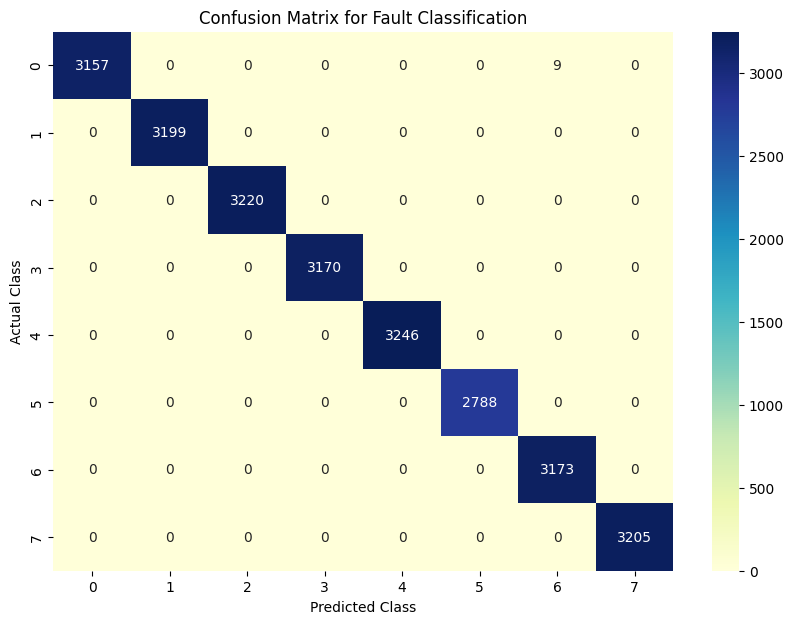

In [ ]:
# Plot confusion matrix for classification performance
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix for Fault Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

787/787 [==============================] - 4s 5ms/step


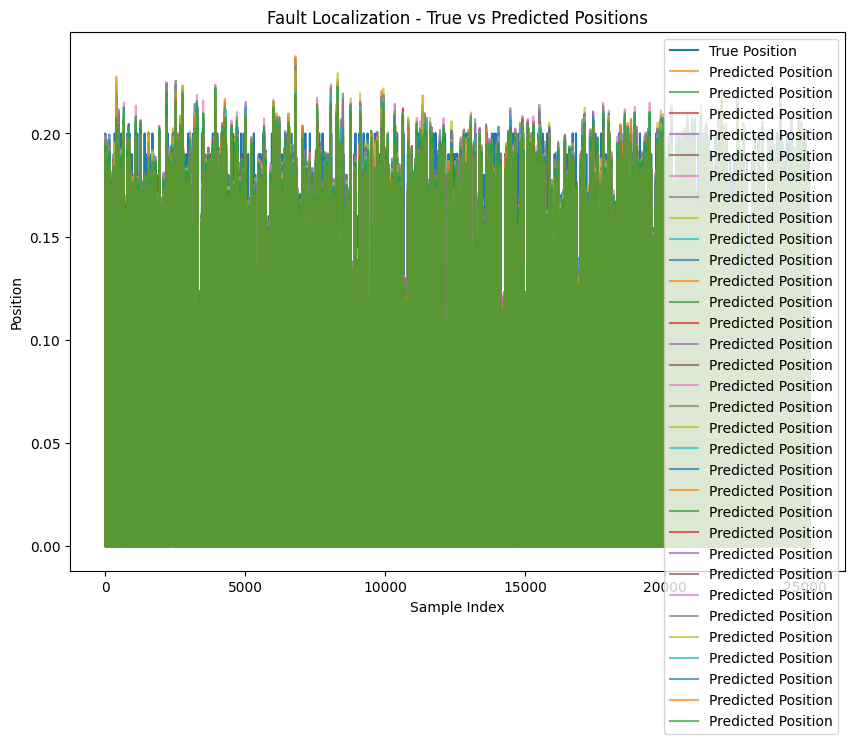

In [ ]:
# Plot predictions vs actual positions to see fault localization accuracy
plt.figure(figsize=(10, 7))
plt.plot(y_test_pos.values, label='True Position')
plt.plot(rnn_model.predict(X_test_rnn), label='Predicted Position', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Position')
plt.title('Fault Localization - True vs Predicted Positions')
plt.legend()
plt.show()